In [1]:
import pennylane as qml

# we indicate the name of the registers and their number of qubits.
wires = qml.registers({"x": 4, "y":4, "output":6,"work_wires": 4})

In [3]:
def product_basis_state(x=0,y=0):
    qml.BasisState(x, wires=wires["x"])
    qml.BasisState(y, wires=wires["y"])

dev = qml.device("default.qubit", shots=1)
@qml.qnode(dev)
def circuit(x,y):
    product_basis_state(x, y)
    return [qml.sample(wires=wires[name]) for name in ["x", "y", "output"]]

circuit(0,0)

[array([0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64)]

In [5]:
def state_to_decimal(binary_array):
    # Convert a binary array to a decimal number
    return sum(bit * (2 ** idx) for idx, bit in enumerate(reversed(binary_array)))

In [6]:
state_to_decimal([1,0,0])

4

In [7]:
output = circuit(x=1,y=4)
print("x register: ", output[0]," (binary) ---> ", state_to_decimal(output[0]), " (decimal)")
print("y register: ", output[1]," (binary) ---> ", state_to_decimal(output[1]), " (decimal)")
print("output register: ", output[2]," (binary) ---> ", state_to_decimal(output[2]), " (decimal)")

x register:  [0 0 0 1]  (binary) --->  1  (decimal)
y register:  [0 1 0 0]  (binary) --->  4  (decimal)
output register:  [0 0 0 0 0 0]  (binary) --->  0  (decimal)


In [8]:
# Adder

@qml.qnode(dev)
def circuit(x):

    product_basis_state(x)          # |x>
    qml.Adder(5, wires["x"])        # |x+5>

    return qml.sample(wires=wires["x"])

print(circuit(x=1), " (binary) ---> ", state_to_decimal(circuit(x=1))," (decimal)")

[0 1 1 0]  (binary) --->  6  (decimal)


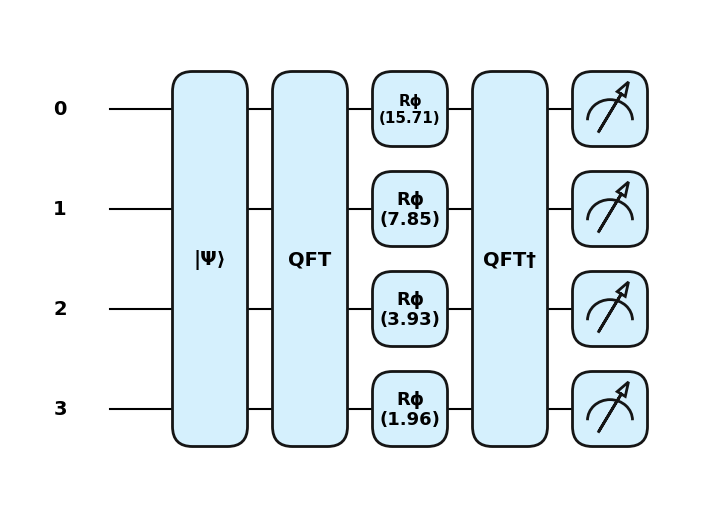

In [10]:
fig, _ = qml.draw_mpl(circuit, decimals = 2, style = "pennylane", level='device')(x=1)

In [11]:
# OutAdder
@qml.qnode(dev)
def circuit(x,y):

    product_basis_state(x, y)                                  #    |x> |y> |0>
    qml.OutAdder(wires["x"], wires["y"], wires["output"])      #    |x> |y> |x+y>

    return qml.sample(wires=wires["output"])

print(circuit(x=2,y=3), " (binary) ---> ", state_to_decimal(circuit(x=2,y=3)), " (decimal)")

[0 0 0 1 0 1]  (binary) --->  5  (decimal)


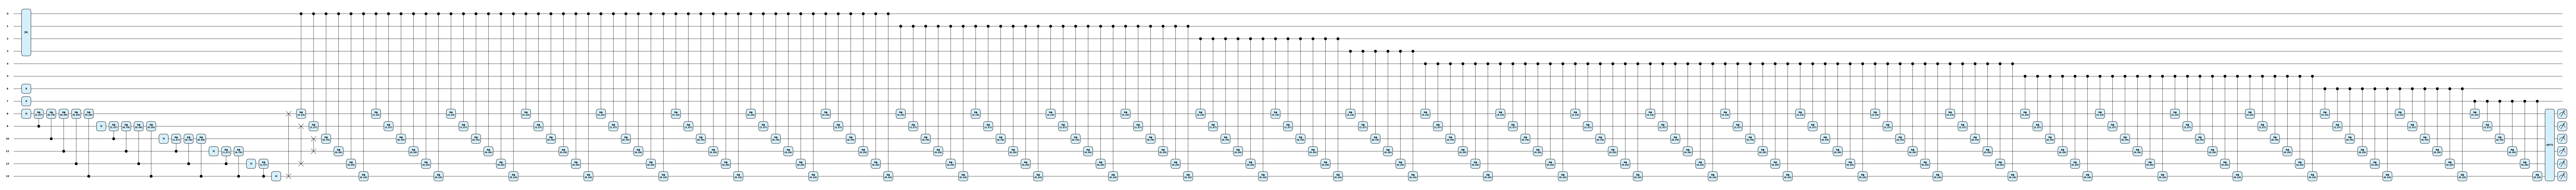

In [12]:
fig, _ = qml.draw_mpl(circuit, decimals = 2, style = "pennylane", level='device')(x=2,y=3)

In [13]:
fig.savefig('outadder.png', bbox_inches='tight')

In [16]:
# multiplier
@qml.qnode(dev)
def circuit(x):

    product_basis_state(x)                                           #    |x>
    qml.Multiplier(3, wires["x"], work_wires=wires["work_wires"])    #    |3x>

    return qml.sample(wires=wires["x"])

print(circuit(x=2), " (binary) ---> ", state_to_decimal(circuit(x=2))," (decimal)")

[0 1 1 0]  (binary) --->  6  (decimal)


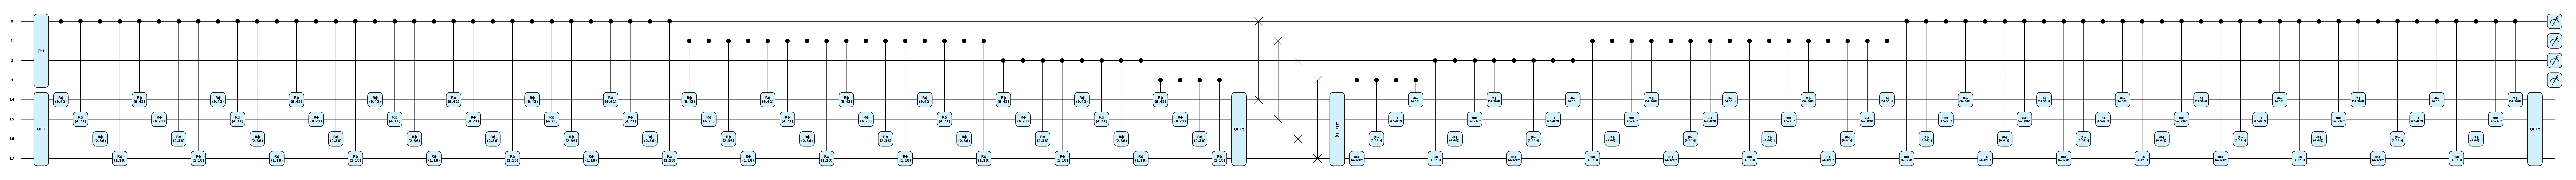

In [18]:
fig, _ = qml.draw_mpl(circuit, decimals = 2, style = "pennylane", level='device')(x=2)

In [19]:
fig.savefig('multiplier.png', bbox_inches='tight')

In [20]:
@qml.qnode(dev)
def circuit(x,y):

    product_basis_state(x, y)                                     #    |x> |y> |0>
    qml.OutMultiplier(wires["x"], wires["y"], wires["output"])    #    |x> |y> |xy>

    return qml.sample(wires=wires["output"])

print(circuit(x=4,y=2), " (binary) ---> ", state_to_decimal(circuit(x=4,y=2))," (decimal)")

[0 0 1 0 0 0]  (binary) --->  8  (decimal)


In [24]:
@qml.qnode(dev)
def circuit(x):

    product_basis_state(x)                     # |x>
    qml.adjoint(qml.Adder(3, wires["x"]))      # |x-3>

    return qml.sample(wires=wires["x"])

print(circuit(x=6), " (binary) ---> ", state_to_decimal(circuit(x=6)), " (decimal)")

[0 0 1 1]  (binary) --->  3  (decimal)


In [25]:
# method to calculate 4 + 3xy + 5x +3y
def adding_3xy():
    # |x> --->  |3x>
    qml.Multiplier(3, wires["x"], work_wires=wires["work_wires"])

    # |3x>|y>|0> ---> |3x>|y>|3xy>
    qml.OutMultiplier(wires["x"], wires["y"], wires["output"])

    # We return the x-register to its original value using the adjoint operation
    # |3x>|y>|3xy>  ---> |x>|y>|3xy>
    qml.adjoint(qml.Multiplier)(3, wires["x"], work_wires=wires["work_wires"])

def adding_5x_3y():

    # |x>|y> --->  |5x>|3y>
    qml.Multiplier(5, wires["x"], work_wires=wires["work_wires"])
    qml.Multiplier(3, wires["y"], work_wires=wires["work_wires"])

    # |5x>|3y>|0> --->  |5x>|3y>|5x + 3y>
    qml.OutAdder(wires["x"], wires["y"], wires["output"])

    # We return the x and y registers to their original value using the adjoint operation
    # |5x>|3y>|5x + 3y> --->  |x>|y>|5x + 3y>
    qml.adjoint(qml.Multiplier)(5, wires["x"], work_wires=wires["work_wires"])
    qml.adjoint(qml.Multiplier)(3, wires["y"], work_wires=wires["work_wires"])

@qml.qnode(dev)
def circuit(x,y):

    product_basis_state(x, y)      #    |x> |y> |0>
    qml.Adder(4, wires["output"])  #    |x> |y> |4>
    adding_3xy()                   #    |x> |y> |4 + 3xy>
    adding_5x_3y()                 #    |x> |y> |4 + 3xy + 5x + 3y>

    return qml.sample(wires=wires["output"])

print(circuit(x=1,y=4), " (binary) ---> ", state_to_decimal(circuit(x=1,y=4)), " (decimal)")

[1 0 0 0 0 1]  (binary) --->  33  (decimal)


In [26]:
# OutPoly for a fast implementation
# This operator automatically takes care of all the arithmetic under the hood. Let’s check out how to apply a function like f(x,y) using OutPoly.
def f(x, y):
   return 4 + 3*x*y + 5*x + 3*y

wires = qml.registers({"x": 4, "y":4, "output":6})
@qml.qnode(dev)
def circuit_with_Poly(x,y):

   product_basis_state(x, y)                         #    |x> |y> |0>
   qml.OutPoly(
       f,
       input_registers= [wires["x"], wires["y"]],
       output_wires = wires["output"])               #    |x> |y> |4 + 3xy + 5x + 3y>

   return qml.sample(wires = wires["output"])

print(circuit_with_Poly(x=1,y=4), " (binary) ---> ", state_to_decimal(circuit_with_Poly(x=1,y=4)), " (decimal)")

[1 0 0 0 0 1]  (binary) --->  33  (decimal)


[0 1]


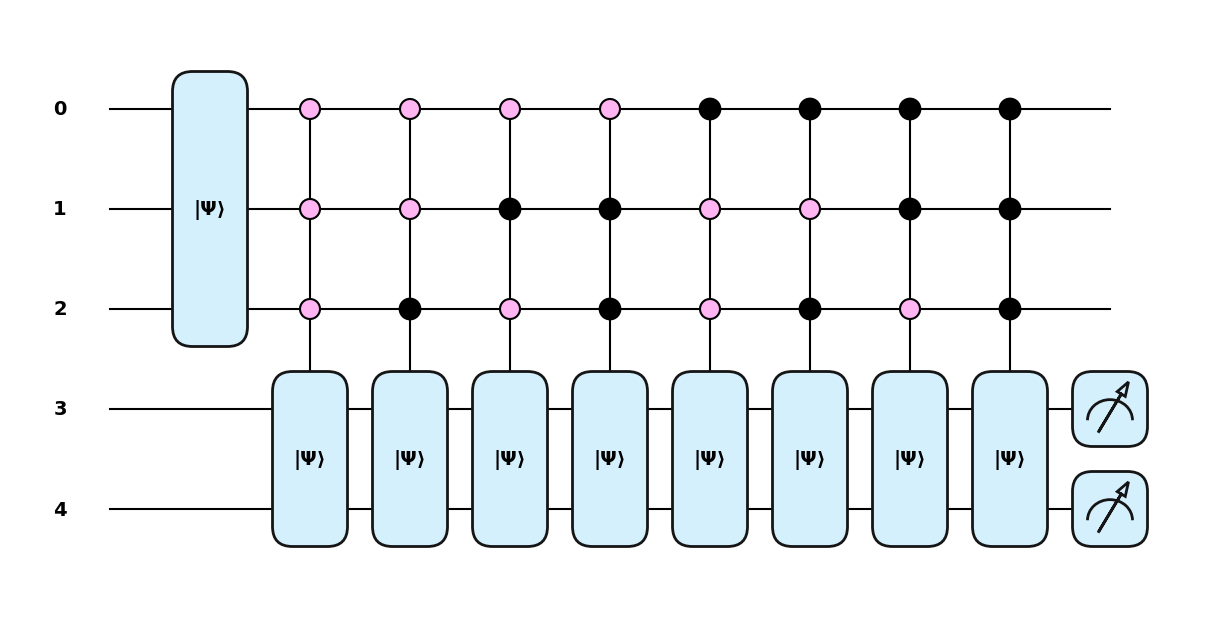

In [31]:
import pennylane as qml
import numpy as np
from functools import partial
import matplotlib.pyplot as plt


bitstrings = ["01", "11", "11", "00", "01", "11", "11", "00"]

control_wires = [0, 1, 2] # index
target_wires = [3, 4] # binary value

Ui = [qml.BasisState(int(bitstring, 2), target_wires) for bitstring in bitstrings]

dev = qml.device("default.qubit", shots=1)


# This line is included for drawing purposes only.
@partial(qml.transforms.decompose, max_expansion=1)

@qml.qnode(dev)
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    qml.Select(Ui, control=control_wires)
    return qml.sample(wires=target_wires)

print(circuit(0))

qml.draw_mpl(circuit, style="pennylane")(0)
plt.show()

In [32]:
# Now we can check that all the outputs are as expected:
for i in range(8):
    print(f"The bitstring stored in index {i} is: {circuit(i)}")

The bitstring stored in index 0 is: [0 1]
The bitstring stored in index 1 is: [1 1]
The bitstring stored in index 2 is: [1 1]
The bitstring stored in index 3 is: [0 0]
The bitstring stored in index 4 is: [0 1]
The bitstring stored in index 5 is: [1 1]
The bitstring stored in index 6 is: [1 1]
The bitstring stored in index 7 is: [0 0]


In [33]:
# The QROM template can be used to implement the previous circuit using directly the bitstring without having to calculate the U_i gates:
import warnings
# This line will suppress ComplexWarnings for output visibility
warnings.filterwarnings(action="ignore", category=np.ComplexWarning)

bitstrings = ["01", "11", "11", "00", "01", "11", "11", "00"]

control_wires = [0, 1, 2]
target_wires = [3, 4]


@partial(qml.compile, basis_set="CNOT")  # Line added for resource estimation purposes only.
@qml.qnode(dev)
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    qml.QROM(bitstrings, control_wires, target_wires, work_wires=None)
    return qml.sample(wires=target_wires)


for i in range(8):
    print(f"The bitstring stored in index {i} is: {circuit(i)}")

The bitstring stored in index 0 is: [0 1]
The bitstring stored in index 1 is: [1 1]
The bitstring stored in index 2 is: [1 1]
The bitstring stored in index 3 is: [0 0]
The bitstring stored in index 4 is: [0 1]
The bitstring stored in index 5 is: [1 1]
The bitstring stored in index 6 is: [1 1]
The bitstring stored in index 7 is: [0 0]


In [36]:
# Although this approach works correctly, the number of multicontrol gates is high — gates with a costly decomposition. 
# Here we show the number of 1 and 2 qubit gates we use when decomposing the circuit:
print("Number of qubits: ", len(control_wires + target_wires))
print("One-qubit gates: ", qml.specs(circuit)(0)["resources"].gate_sizes[1])
print("Two-qubit gates: ", qml.specs(circuit)(0)["resources"].gate_sizes[2])

Number of qubits:  5
One-qubit gates:  1060
Two-qubit gates:  480


In [37]:
# swap
# using multiple auxiliary qubits, we reduce the circuit depth required to build the QROM
bitstrings = ["01", "11", "11", "00", "01", "11", "11", "00"]

control_wires = [0, 1, 2]
target_wires = [3, 4]
work_wires = [5, 6]


@partial(qml.compile, basis_set="CNOT")
@qml.qnode(dev)
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    #  added work wires below
    qml.QROM(bitstrings, control_wires, target_wires, work_wires, clean=False)
    return qml.sample(wires=control_wires + target_wires + work_wires)

print("Number of qubits: ", len(control_wires + target_wires + work_wires))
print("One-qubit gates: ", qml.specs(circuit)(0)["resources"].gate_sizes[1])
print("Two-qubit gates: ", qml.specs(circuit)(0)["resources"].gate_sizes[2])

Number of qubits:  7
One-qubit gates:  223
Two-qubit gates:  96


In [38]:
index = 5
output = circuit(index)
print(f"control wires: {output[:3]}")
print(f"target wires: {output[3:5]}")
print(f"work wires: {output[5:7]}")

control wires: [1 0 1]
target wires: [1 1]
work wires: [0 1]


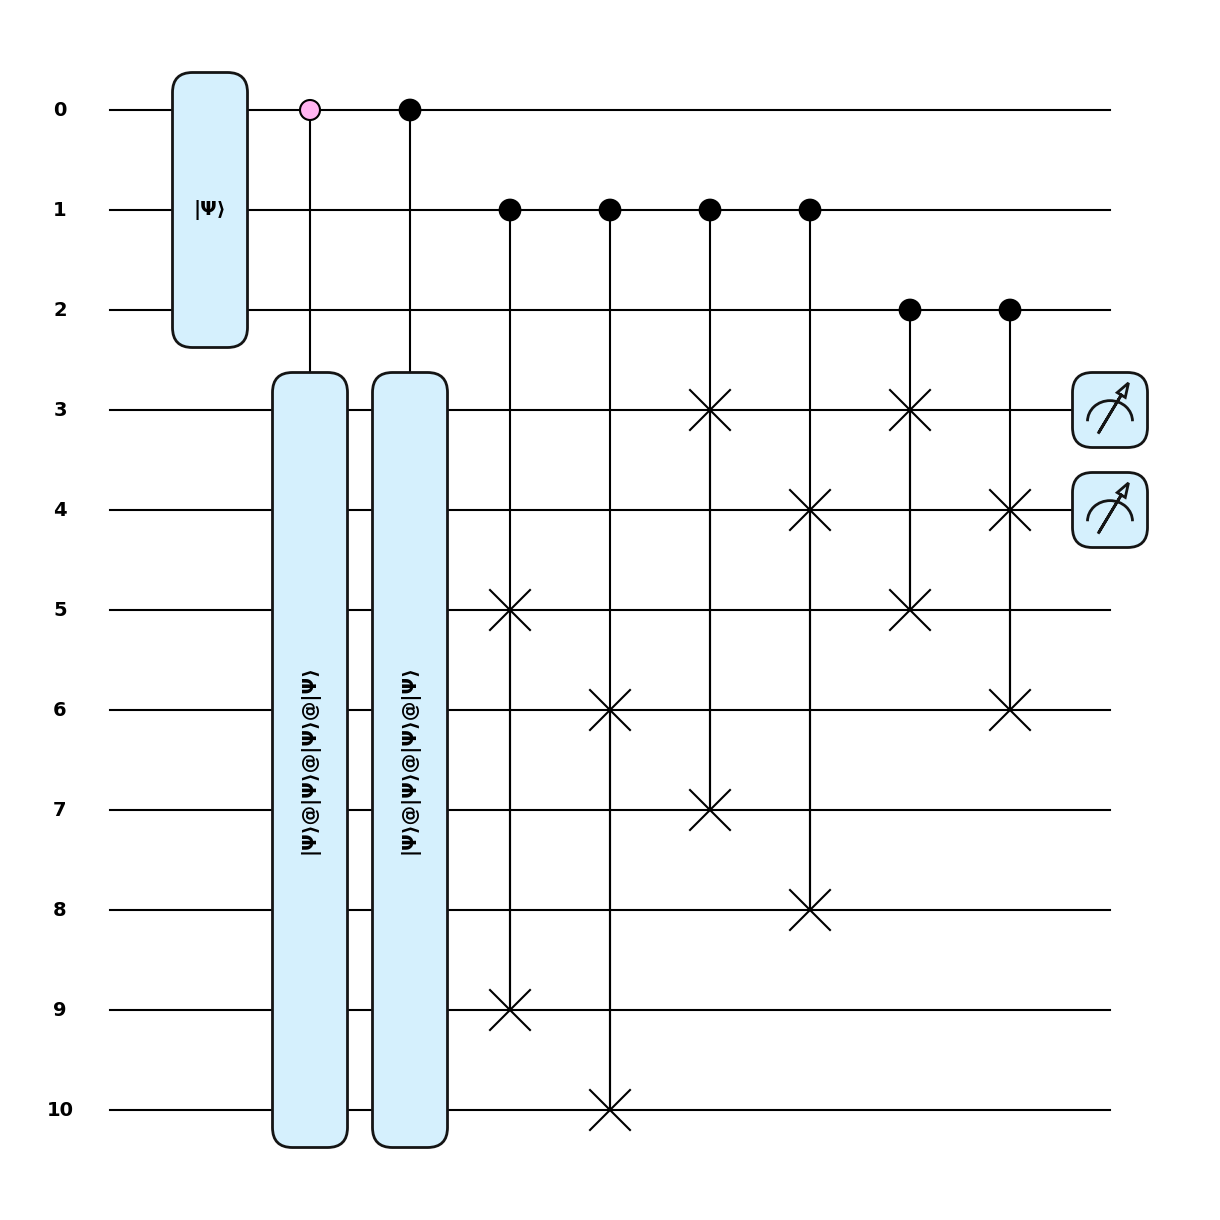

In [40]:
# The QROM template will put as many rows as possible using the work_wires we pass. Let’s check how it looks in PennyLane:
bitstrings = ["01", "11", "11", "00", "01", "11", "11", "00"]

control_wires = [0, 1, 2]
target_wires = [3, 4]
work_wires = [5, 6, 7, 8, 9, 10, 11, 12]


# Line added for drawing purposes only
@partial(qml.transforms.decompose, max_expansion=2)
@qml.qnode(qml.device("default.qubit", shots=1))
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    qml.QROM(bitstrings, control_wires, target_wires, work_wires, clean=False) ## work wires may change
    return qml.sample(wires=target_wires), qml.sample(wires=target_wires)


qml.draw_mpl(circuit, style="pennylane")(0)
plt.show()

In [41]:
# clean=True to fix work_wires
bitstrings = ["01", "11", "11", "00", "01", "11", "11", "00"]

control_wires = [0, 1, 2]
target_wires = [3, 4]
work_wires = [5, 6]


@qml.qnode(dev)
def circuit(index):
    qml.BasisState(index, wires=control_wires)
    qml.QROM(bitstrings, control_wires, target_wires, work_wires, clean=True)
    return qml.sample(wires=target_wires + work_wires)


for i in range(8):
    print(f"The bitstring stored in index {i} is: {circuit(i)[:2]}")
    print(f"The work wires for that index are in the state: {circuit(i)[2:4]}\n")

The bitstring stored in index 0 is: [0 1]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 1 is: [1 1]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 2 is: [1 1]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 3 is: [0 0]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 4 is: [0 1]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 5 is: [1 1]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 6 is: [1 1]
The work wires for that index are in the state: [0 0]

The bitstring stored in index 7 is: [0 0]
The work wires for that index are in the state: [0 0]



In [46]:
N = 3
wires = range(N)
dev = qml.device("default.qubit", wires)

@qml.qnode(dev)
def circuit(features):
    qml.AmplitudeEmbedding(features, wires, normalize=True)
    return qml.state()

circuit([0.625, 0.0, 0.0, 0.0, 0.625j, 0.375, 0.25+0.1j, 0.125])

array([0.62189824+0.j        , 0.        +0.j        ,
       0.        +0.j        , 0.        +0.j        ,
       0.        +0.62189824j, 0.37313895+0.j        ,
       0.2487593 +0.09950372j, 0.12437965+0.j        ])

In [69]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(feature_vector):
    qml.AngleEmbedding(features=feature_vector, wires=range(3), rotation='Y')
    # qml.Hadamard(0)
    return qml.probs(wires=range(3))

circuit([np.pi, 0, np.pi])

array([1.40579963e-65, 3.74939946e-33, 0.00000000e+00, 0.00000000e+00,
       3.74939946e-33, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

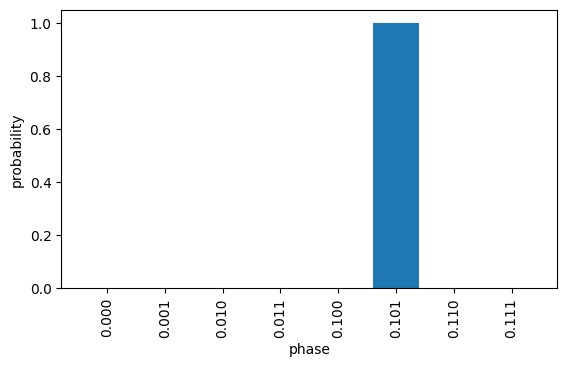

In [70]:
results = circuit([np.pi, 0, np.pi])

bit_strings = [f"0.{x:0{len(range(3))}b}" for x in range(len(results))]

plt.bar(bit_strings, results)
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)

plt.show()

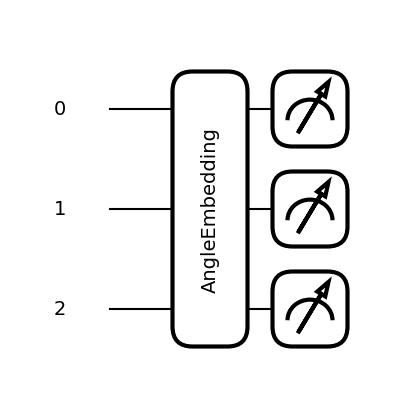

In [63]:
fig, axs = qml.draw_mpl(circuit)([0, np.pi, 0])